## Import Libraries

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Convert Raw video datasets into a 320x240 at 30fps

In [ ]:
def downgrade_video_quality(input_folder, output_folder, target_width=320, target_height=240, target_fps=30):
    """
    Downgrades the quality of videos in a given folder and organizes them by exercise name.

    Args:
        input_folder: The path to the folder containing the raw videos.
        output_folder: The path to the folder where the downgraded videos will be saved.
        target_width: The desired width of the output videos.
        target_height: The desired height of the output videos.
        target_fps:  The desired frames per second.  Crucially, get from the original.
    """

    # Create the output folder and subfolders if they don't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for exercise_name in os.listdir(input_folder):
        exercise_path = os.path.join(input_folder, exercise_name)

        # Check if it's a directory (to avoid processing non-directory files)
        if os.path.isdir(exercise_path):
            output_exercise_path = os.path.join(output_folder, exercise_name)
            if not os.path.exists(output_exercise_path):
                os.makedirs(output_exercise_path)

            for filename in os.listdir(exercise_path):
                if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):  # Add more extensions if needed
                    input_filepath = os.path.join(exercise_path, filename)
                    output_filepath = os.path.join(output_exercise_path, filename)

                    try:
                        # Open the video file
                        video_capture = cv2.VideoCapture(input_filepath)

                        # Check if video opened successfully
                        if not video_capture.isOpened():
                            print(f"Error: Could not open video {input_filepath}")
                            continue

                        # Get original video properties
                        original_fps = video_capture.get(cv2.CAP_PROP_FPS)
                        # original_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) #Not used
                        # original_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) #Not used
                        
                        # Use the original FPS if target_fps is not specified or is invalid
                        fps_to_use = original_fps if original_fps > 0 else target_fps

                        # Define the codec and create VideoWriter object
                        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for AVI, or other codecs as needed
                        out = cv2.VideoWriter(output_filepath, fourcc, fps_to_use, (target_width, target_height))


                        while True:
                            ret, frame = video_capture.read()
                            if not ret:
                                break  # End of video

                            # Resize the frame
                            resized_frame = cv2.resize(frame, (target_width, target_height))

                            # Write the resized frame to the output video
                            out.write(resized_frame)

                        # Release resources
                        video_capture.release()
                        out.release()
                        print(f"Processed: {input_filepath} -> {output_filepath}")

                    except Exception as e:
                        print(f"Error processing {input_filepath}: {e}")

    print("Video processing complete.")



if __name__ == '__main__':
    raw_folder = "raw"  # Replace with the actual path to your raw videos folder
    downgraded_folder = "downgraded_raw"  # The output folder

    downgrade_video_quality(raw_folder, downgraded_folder)

### Set Numpy, Python, and TF seeds

In [3]:
spatial_input_size = (224,224,3)
temporal_input_size = (320, 240, 1)
seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

## Visualize Data for 1st CNN stream


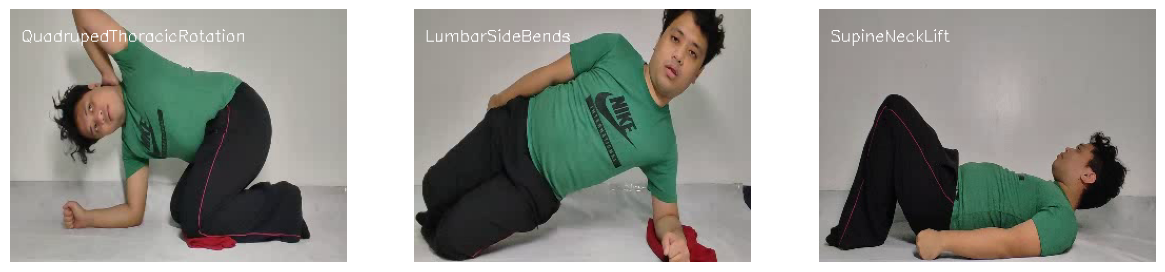

In [4]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('downgraded_raw')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'downgraded_raw/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'downgraded_raw/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


## PreProcess the Dataset

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH =  224, 224 #for rgb/1st stream

SEQUENCE_LENGTH = 20

DATASET_DIR = r"D:\MAPUA\CNN_GRU_usingRGBOF\downgraded_raw"

CLASSES_LIST = ['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']

## Extraction of Features 

1st Stream

In [6]:
def frames_extraction_RGB(video_path):
    """Extract frames from video and return normalized RGB frames"""
    frames_list1 = []
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the position of the next frame to read
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read()
        if not success:
            break
        
        # Convert BGR (default in OpenCV) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize to target dimensions and normalize to [0, 1]
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0
        
        frames_list1.append(normalized_frame)
    
    video_reader.release()
    
    # Determine a padding frame if fewer than SEQUENCE_LENGTH frames were extracted
    if frames_list1:
        pad_frame = np.zeros_like(frames_list1[0])
    else:
        pad_frame = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
    
    # Pad the list to ensure the length is SEQUENCE_LENGTH
    while len(frames_list1) < SEQUENCE_LENGTH:
        frames_list1.append(pad_frame)
    
    return frames_list1


2nd CNN Stream

###### Get optical flow frames

In [7]:
def compute_optical_flow(prev_frame, next_frame):
    """
    Compute optical flow using the Lucas-Kanade method between two frames.
    
    Returns:
        good_old: Array of points from the previous frame.
        good_new: Array of corresponding points from the next frame.
    """
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21),
                     maxLevel=3,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Parameters for Shi-Tomasi corner detection (good features to track)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    
    # Detect features in the previous frame
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    if p0 is None:
        return [], []

    # Calculate optical flow (find corresponding points in the next frame)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Ensure valid output and select good points based on the status array
    if p1 is not None and st is not None:
        st = st.flatten()
        good_old = p0[st == 1]
        good_new = p1[st == 1]
    else:
        good_old, good_new = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    """
    Create Motion Energy Image (MEI) and Motion History Image (MHI) from optical flow vectors.
    
    Args:
        flow: Tuple containing (good_old, good_new) points.
        shape: Tuple defining the output image size (height, width).
        tau: Time constant for motion decay in the MHI.
        
    Returns:
        mei: The Motion Energy Image (binary representation of motion).
        mhi: The Motion History Image (captures motion intensity with decay).
    """
    # Initialize MEI and MHI as zero arrays
    mei = np.zeros(shape, dtype=np.float32)
    mhi = np.zeros(shape, dtype=np.float32)

    # Iterate over each pair of corresponding points to draw motion vectors
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw a line for the motion on the MEI (binary, using a fixed thickness)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw the same line on the MHI (this will later be decayed over time)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Apply decay to the MHI (simulate motion fading over time)
    mhi[mhi > 0] -= 255 / tau  
    mhi[mhi < 0] = 0  # Clip negative values to 0

    return mei, mhi

def frames_extraction_OF(video_path, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH):
    """
    Extracts Motion Energy Images (MEI) from a video by computing optical flow between frame pairs.
    
    Args:
        video_path: Path to the video file.
        SEQUENCE_LENGTH: Number of frame pairs (and thus MEI images) to extract.
        IMAGE_HEIGHT: Target height for resizing frames.
        IMAGE_WIDTH: Target width for resizing frames.
    
    Returns:
        A 4D NumPy array of shape (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
        containing the normalized MEI images.
    """
    frames_list2 = []

    # Open the video file
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return frames_list2

    # Total frames and skip window calculation for even sampling
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate over the video using the skip window to select frame pairs
    for frame_counter in range(0, video_frames_count - skip_frames_window, skip_frames_window):
        # Read the previous frame
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        success, prev_frame = video_reader.read()
        if not success:
            break

        # Read the next frame
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter + skip_frames_window)
        success, next_frame = video_reader.read()
        if not success:
            break

        # Resize frames to target dimensions. Note: cv2.resize expects (width, height)
        prev_frame_resized = cv2.resize(prev_frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        next_frame_resized = cv2.resize(next_frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Compute optical flow between the two frames
        good_old, good_new = compute_optical_flow(prev_frame_resized, next_frame_resized)

        # If no valid optical flow vectors were found, skip this pair
        if len(good_old) == 0 or len(good_new) == 0:
            print(f"Warning: No optical flow vectors found for frames {frame_counter} and {frame_counter + skip_frames_window}.")
            continue

        # Create the Motion Energy Image (MEI) from the optical flow vectors
        mei, _ = create_mei_mhi((good_old, good_new), (IMAGE_HEIGHT, IMAGE_WIDTH), tau=10)

        # Normalize the MEI to 0-255 and convert to an 8-bit image for visualization
        mei_norm = cv2.normalize(mei, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Expand dimensions to add a channel axis (resulting in shape: H x W x 1)
        mei_norm = np.expand_dims(mei_norm, axis=-1)

        # Append the normalized MEI image to the list
        frames_list2.append(mei_norm)

    # Release the video capture
    video_reader.release()

    # If fewer than SEQUENCE_LENGTH frames were extracted, pad with zero-frames
    while len(frames_list2) < SEQUENCE_LENGTH:
        frames_list2.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.uint8))

    # If more than SEQUENCE_LENGTH frames were collected, truncate the list
    if len(frames_list2) > SEQUENCE_LENGTH:
        frames_list2 = frames_list2[:SEQUENCE_LENGTH]

    # Convert the list of frames to a 4D NumPy array
    frames_list2 = np.stack(frames_list2, axis=0)

    return frames_list2

## Dataset Creation

1st Stream

In [8]:
def create_dataset_1st():
    """Creates the dataset for the first (RGB) stream with flipping and rotation augmentations."""
    features1 = []
    labels1 = []
    video_files_paths1 = []
    
    # Create an ImageDataGenerator with rotation and horizontal flip augmentations.
    datagen = ImageDataGenerator(
        rotation_range=15,        # Allow rotations up to 15 degrees.
        horizontal_flip=True,     # Enable horizontal flipping.
        fill_mode='nearest'       # Strategy to fill in newly created pixels.
    )
    
    # Iterate over each class in the dataset.
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)
        
        # Process each video file in the current class directory.
        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            try:
                # Extract the original frames using the defined function.
                frames = frames_extraction_RGB(video_file_path)
                
                # Only proceed if the number of extracted frames equals SEQUENCE_LENGTH.
                if len(frames) == SEQUENCE_LENGTH:
                    # Add the original frames to the features list.
                    features1.append(frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path)
                    
                    # Create an augmented version of the frames.
                    augmented_frames = []
                    # Generate a random seed that will be used for every frame in the sequence
                    # to ensure a consistent transformation across the entire video.
                    seed = np.random.randint(1000)
                    
                    for frame in frames:
                        # Expand dimensions to match the input shape expected by ImageDataGenerator.
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        # Generate the augmented frame.
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    # Append the augmented frames as a separate sample.
                    features1.append(augmented_frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path + '_aug')
                else:
                    print(f"Warning: {video_file_path} did not yield {SEQUENCE_LENGTH} frames.")
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    # Convert lists to NumPy arrays.
    features1 = np.array(features1)
    labels1 = np.array(labels1)
    
    return features1, labels1, video_files_paths1


In [9]:
features1, labels1, video_files_paths1 = create_dataset_1st()
    

print(f"Features shape: {features1.shape}")
print(f"Labels shape: {labels1.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths1)}")

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (420, 20, 224, 224, 3)
Labels shape: (420,)
Number of videos (including augmented): 420


In [10]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels1 = to_categorical(labels1, num_classes=len(CLASSES_LIST))

In [12]:
# Display the converted labels
unique_labels1, counts1 = np.unique(labels1, return_counts=True)
for label, count in zip(unique_labels1, counts1):
    print(f"Label {label}: {count} instances")

Label 0: 140 instances
Label 1: 140 instances
Label 2: 140 instances


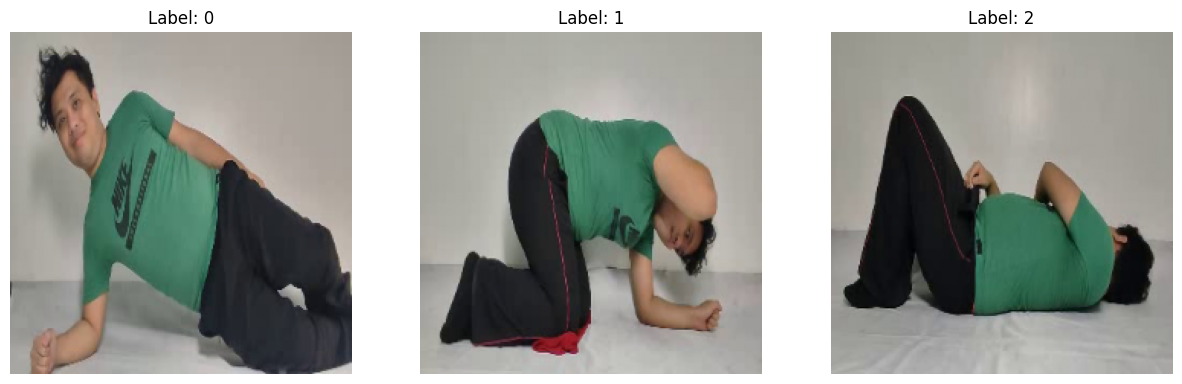

In [13]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels1):
    # Find the first index of the current label
    index = np.where(labels1 == label)[0][0]

#Extract the corresponding video frames
    frames = features1[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

2nd Stream

In [15]:
def create_dataset_2nd():
    """Creates the dataset with only flipping and rotation augmentations for the optical flow stream."""
    features2 = []
    labels2 = []
    video_files_paths2 = []
    
    # Create an ImageDataGenerator for applying rotation and horizontal flip augmentations.
    datagen = ImageDataGenerator(
        rotation_range=15,        # Rotate images up to 15 degrees.
        horizontal_flip=True,     # Apply horizontal flipping.
        fill_mode='nearest'       # Define how to fill pixels when transformations create new empty areas.
    )
    
    # Loop over each class directory
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        class_dir = os.path.join(DATASET_DIR, class_name)
        files_list = os.listdir(class_dir)
        
        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            try:
                # Extract the optical flow frames using the frames_extraction_OF function.
                # Note: The parameters (SEQUENCE_LENGTH, 320, 240) specify the number of frames and the target dimensions.
                frames = frames_extraction_OF(video_file_path, SEQUENCE_LENGTH, 320, 240)
                
                if len(frames) == SEQUENCE_LENGTH:
                    # Save the original optical flow frames.
                    features2.append(frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path)
                    
                    # Create an augmented version of the optical flow frames.
                    augmented_frames = []
                    seed = np.random.randint(1000)  # Use the same seed for all frames to maintain consistency across the sequence.
                    
                    for frame in frames:
                        frame_expanded = np.expand_dims(frame, 0)
                        it = datagen.flow(frame_expanded, batch_size=1, seed=seed)
                        augmented_frame = next(it)[0]
                        augmented_frames.append(augmented_frame)
                    
                    # Append the augmented sample.
                    features2.append(augmented_frames)
                    labels2.append(class_index)
                    video_files_paths2.append(video_file_path + '_aug')
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    # Convert the collected lists to NumPy arrays.
    features2 = np.array(features2)
    labels2 = np.array(labels2)
    
    return features2, labels2, video_files_paths2


In [16]:
features2, labels2, video_files_paths2 = create_dataset_2nd()
    

print(f"Features shape: {features2.shape}")
print(f"Labels shape: {labels2.shape}")
print(f"Number of videos (including augmented): {len(video_files_paths2)}")

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift
Features shape: (420, 20, 320, 240, 1)
Labels shape: (420,)
Number of videos (including augmented): 420


In [17]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels2 = to_categorical(labels2,num_classes=len(CLASSES_LIST))

In [18]:
# Display the converted labels 
unique_labels2, counts2 = np.unique(labels2, return_counts=True)
for label, count in zip(unique_labels2, counts2):
    print(f"Label {label}: {count} instances")

Label 0: 140 instances
Label 1: 140 instances
Label 2: 140 instances


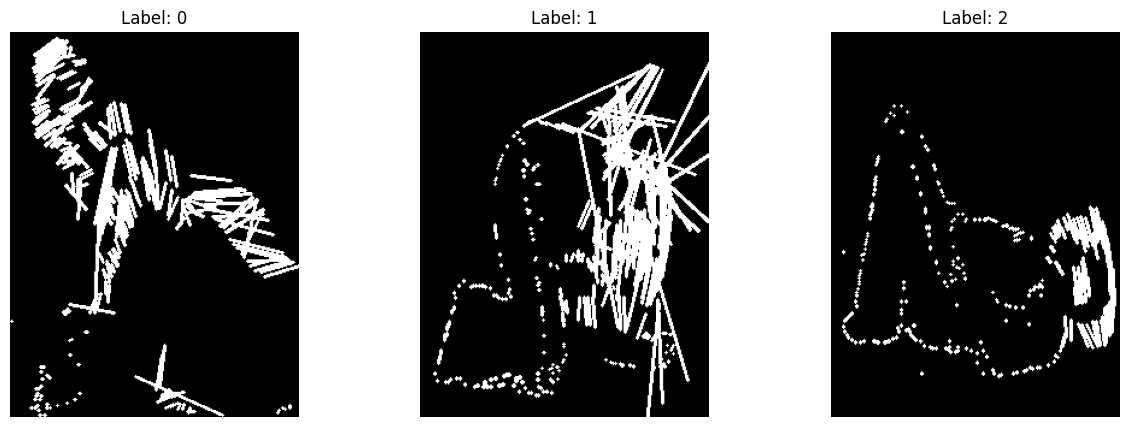

In [19]:
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels2):
    # Find the first index of the current label
    index = np.where(labels2 == label)[0][0]

#Extract the corresponding video frames
    frames = features2[index]

#Select a random frame instead of the middle one
    random_frame = frames[np.random.randint(0, len(frames))]

#Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_frame, cmap="grey")
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

## Split Data into Train, Test, and Validation

For 1st Stream (RBG Data)

In [20]:
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features1, one_hot_encoded_labels1,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train1, features_val1, labels_train1, labels_val1 = train_test_split(
    features_train1, labels_train1, test_size=0.20, shuffle=True, random_state=seed_constant
)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train1)}")
print(f"Number of validation samples: {len(features_val1)}")
print(f"Number of testing samples: {len(features_test1)}")


Number of training samples: 268
Number of validation samples: 68
Number of testing samples: 84


For 2nd Stream (OF Data)

In [21]:
features_train2, features_test2, labels_train2, labels_test2 = train_test_split(features2, one_hot_encoded_labels2,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)
features_train2, features_val2, labels_train2, labels_val2 = train_test_split(
    features_train2, labels_train2, test_size=0.20, shuffle=True, random_state=seed_constant
)

# Display the number of samples in each set
print(f"Number of training samples: {len(features_train2)}")
print(f"Number of validation samples: {len(features_val2)}")
print(f"Number of testing samples: {len(features_test2)}")

Number of training samples: 268
Number of validation samples: 68
Number of testing samples: 84


## Implement 2stream Model

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, GRU, Dropout, Dense, Conv2D, MaxPooling2D, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

In [262]:
# Define input shapes
rgb_input_shape = (features1.shape[1:])  # (Time steps, Height, Width, Channels)
of_input_shape = (features2.shape[1:])   # (Time steps, Height, Width, OF Channels)
num_classes = 3 # Example: 10 action classes

print(rgb_input_shape)
print(of_input_shape)

(20, 224, 224, 3)
(20, 320, 240, 1)


Define the RGB CNN Architecture

In [ ]:
def create_rgb_stream_model(seq_length=20, input_shape=(224, 224, 3),
                            gru_units=64, dropout_rate=0.5, feature_dim=64):
    # Use MobileNetV2 as the base CNN; load pre-trained weights from ImageNet.
    base_cnn = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet')
    base_cnn.trainable = False  # Freeze the pre-trained layers
    
    rgb_input = Input(shape=(seq_length, ) + input_shape, name="rgb_input")
    
    x = TimeDistributed(base_cnn, name="time_distributed_cnn")(rgb_input)

    x = TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_gap")(x)

    x = GRU(gru_units, return_sequences=False, name="gru_layer")(x)
    x = Dropout(dropout_rate, name="gru_dropout")(x)
    
    output = Dense(feature_dim, activation='relu', name="rgb_feature_vector")(x)

    model = Model(inputs=rgb_input, outputs=output, name="RGB_Stream_Model")
    return model

In [24]:
# Create the RGB model
rgb_model = create_rgb_stream_model()
rgb_model.summary()

Model: "RGB_Stream_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rgb_input (InputLayer)      [(None, 20, 224, 224, 3)  0         
                             ]                                   
                                                                 
 time_distributed_cnn (TimeD  (None, 20, 7, 7, 1280)   2257984   
 istributed)                                                     
                                                                 
 time_distributed_gap (TimeD  (None, 20, 1280)         0         
 istributed)                                                     
                                                                 
 gru_layer (GRU)             (None, 64)                258432    
                                                                 
 gru_dropout (Dropout)       (None, 64)                0         
                                                  

Define the Optical Flow CNN architecture

In [ ]:
def create_optical_flow_stream_model(seq_length=20, input_shape=(320, 240, 1),
                                     gru_units=64, dropout_rate=0.5, feature_dim=64):
    
    flow_input = Input(shape=(seq_length, ) + input_shape, name="flow_input")
    
    # Build a shallow CNN architecture for each frame.
    x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'),
                        name="td_conv1")(flow_input)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool1")(x)
    
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'),
                        name="td_conv2")(x)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool2")(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
                        name="td_conv3")(x)
    x = TimeDistributed(MaxPooling2D((2, 2)), name="td_pool3")(x)

    x = TimeDistributed(GlobalAveragePooling2D(), name="td_gap")(x)
    

    x = GRU(gru_units, return_sequences=False, name="gru_flow")(x)
    x = Dropout(dropout_rate, name="gru_flow_dropout")(x)
    
    output = Dense(feature_dim, activation='relu', name="flow_feature_vector")(x)
    
    model = Model(inputs=flow_input, outputs=output, name="OpticalFlow_Stream_Model")
    return model

In [27]:
optical_flow_model = create_optical_flow_stream_model()  # Corrected call
optical_flow_model.summary()

Model: "OpticalFlow_Stream_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flow_input (InputLayer)     [(None, 20, 320, 240, 1)  0         
                             ]                                   
                                                                 
 td_conv1 (TimeDistributed)  (None, 20, 320, 240, 16)  160       
                                                                 
 td_pool1 (TimeDistributed)  (None, 20, 160, 120, 16)  0         
                                                                 
 td_conv2 (TimeDistributed)  (None, 20, 160, 120, 32)  4640      
                                                                 
 td_pool2 (TimeDistributed)  (None, 20, 80, 60, 32)    0         
                                                                 
 td_conv3 (TimeDistributed)  (None, 20, 80, 60, 64)    18496     
                                          

In [ ]:
def create_late_fusion_model(rgb_model, flow_model, num_classes, 
                             fusion_dropout=0.5, dense_units=128):
    """
    Creates a late fusion model that combines the feature outputs from the 
    RGB stream and the Optical Flow stream models.
    """

    rgb_input = rgb_model.input
    flow_input = flow_model.input
    
    # Get the output feature vectors from each model.
    rgb_features = rgb_model.output    # shape: (feature_dim,)
    flow_features = flow_model.output  # shape: (feature_dim,)
    
    # Fuse the features using concatenation.
    fused_features = Concatenate(name='fusion_concat')([rgb_features, flow_features])

    x = Dropout(fusion_dropout, name='fusion_dropout')(fused_features)
    x = Dense(dense_units, activation='relu', name='fusion_dense')(x)
    
    # Final classification layer.
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=[rgb_input, flow_input], outputs=outputs, name='Late_Fusion_Model')
    
    return model

##### Display Architecture

In [30]:
num_classes = 3
late_fusion_model = create_late_fusion_model(rgb_model, optical_flow_model, num_classes)
late_fusion_model.summary()

Model: "Late_Fusion_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flow_input (InputLayer)        [(None, 20, 320, 24  0           []                               
                                0, 1)]                                                            
                                                                                                  
 td_conv1 (TimeDistributed)     (None, 20, 320, 240  160         ['flow_input[0][0]']             
                                , 16)                                                             
                                                                                                  
 td_pool1 (TimeDistributed)     (None, 20, 160, 120  0           ['td_conv1[0][0]']               
                                , 16)                                             

## Train the Model

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [44]:
late_fusion_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('late_fusion_model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = late_fusion_model.fit(
    [features_train1, features_train2],
    labels_train1,
    validation_data=([features_val1, features_val2], labels_val1),
    epochs=100,
    batch_size=4,  # Reduced batch size
    callbacks=[early_stopping, model_checkpoint]
)

MemoryError: Unable to allocate 3.01 GiB for an array with shape (268, 20, 224, 224, 3) and data type float32

## Evaluate Model